In [ ]:
import ibmJupyterNotebookStyles
ibmJupyterNotebookStyles.apply_ibm_styles()

# Optimizers

In [1]:
import ibmJupyterNotebookStyles
ibmJupyterNotebookStyles.apply_ibm_styles()

In this module we cover some common optimization algorithms.  Typically the numerical methods used in optimization have three components:

* Initial guess
* Direction for improvement
* Size of step to make on the direction

Depending on whether one specifies the direction or the size of the step, we can use the line search or trusted region methods. Some of these algorithms use gradient to provide a direction, but the gradient calculation may be quite expensive computationally; we also may not know the function to compute its gradient.  Other algorithms do not require the calculation of a gradient. 

We start in this notebook by showing how to optimize a function using exact methods. We then show a common numerical method called Gradient Descent, and demonstrate how it is used to optimize a function.

In [2]:
import numpy as np
from sympy import *
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
%matplotlib inline

## Define the function to use
We will use `sympy` to calculate Jacobian and Hessian matrices. We will use the Rosenbrock function $100(x_2-x_1^2)^2+(1-x_1)^2$ as an example. 

In [3]:
def func(x,y):
    return 100*(y-x**2)**2+(1-x)**2
x1,x2=symbols("x1 x2")
f=Matrix([100*(x2-x1**2)**2+(1-x1)**2])
X=Matrix([x1,x2])
f

Matrix([[(1 - x1)**2 + 100*(-x1**2 + x2)**2]])

The gradient is given by:

In [4]:
f.jacobian(X)

Matrix([[-400*x1*(-x1**2 + x2) + 2*x1 - 2, -200*x1**2 + 200*x2]])

We derive the first-order conditions by solving for the gradient equal to zero. The point (1,1) is a *stationary point*.

In [5]:
x_star=solve(f.jacobian(X))
x_star

[{x1: 1, x2: 1}]

The Hessian is given by

In [6]:
H=hessian(f,X)
H

Matrix([
[1200*x1**2 - 400*x2 + 2, -400*x1],
[                -400*x1,     200]])

and the second-order necessary conditions state that the Hessian for the stationary point has to be positive definite.

In [7]:
H_star=H.evalf(subs={x1:1,x2:1})
H_star

Matrix([
[ 802.0, -400.0],
[-400.0,  200.0]])

In [8]:
H_star.is_positive_definite

True

Since the Hessian `H_star` at `x_star` is positive definite, `x_star` is a strict local minimizer of the function `f`. Here is a contour plot of the function where the red point is the minimum `x_star`.

In [9]:
def make_contours():
    grid_samples=100
    domain = [(-2, 2), (-0.5, 2)] 
    x = np.linspace(domain[0][0], domain[0][1], grid_samples)
    y = np.linspace(domain[1][0], domain[1][1], grid_samples)
    X, Y = np.meshgrid(x, y)  
    fn_vectorized = np.vectorize(func)
    Z = fn_vectorized(X, Y)
    return X,Y,Z

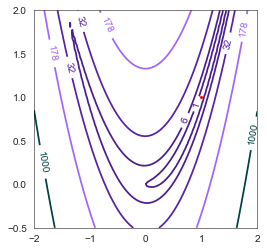

In [10]:
grid_samples=100
X,Y,Z=make_contours()
    
fig,ax = plt.subplots(figsize=(4,4))
levels = np.logspace(0, 3,5)
contour_plt=ax.contour(X, Y, Z,levels) #[0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5])
plt.clabel(contour_plt, inline=1, fontsize=10, fmt =  '%1.0f')
ax.plot([1],[1],'ro',markersize=3)



## The gradient descent (GD) algorithm

The gradent descent (GD) algorithm is a numerical line search algorithm. The majority of these algorithms starts with an initial guess, and loops over the steps of identifying a direction to improve and defining how far to move in that direction. In GD the direction is that of the gradient at the current point $\mathbf{x}^k$, 
    $$ \mathbf{g}^k= \nabla f(\mathbf{x}^k) \ \ ,$$
or its normalization 
$$\mathbf{d}^k= -\mathbf{g}^k/\| \mathbf{g}^k\| \ \ .$$ 
In its simplest form the algorithm has a set step $\alpha$. There are many strategies to adapt $\alpha$ at each iteration, and certain criteria that $\alpha$ needs to satisfy for the algorithm to converge. The algorithm goes as follows:
1. Set step $\alpha$, $k=0$ and initial guess $\mathbf{x}^0$.
2. Calculate the gradient at $\mathbf{x}^k$,  and $\mathbf{d}^k$.
3. Calculate $\mathbf{x}^{k+1} = \mathbf{x}^k - \alpha \mathbf{d}^k$ and update $\alpha$.
4. If $\| \mathbf{x}^{k+1} - \mathbf{x}^k \| < \epsilon$, terminate; otherwise, go to Step 2.

The need to update $\alpha$ in step 3 will become clear below. In the initial algorithm $\alpha$ is constant.


We will use the same function as above. First we get the gradient:

In [11]:
def func(x,y):
    return 100*(y-x**2)**2+(1-x)**2
x1,x2=symbols("x1 x2")
f=Matrix([100*(x2-x1**2)**2+(1-x1)**2])
X=Matrix([x1,x2])
f

Matrix([[(1 - x1)**2 + 100*(-x1**2 + x2)**2]])

In [12]:
g=lambdify((x1,x2),f.jacobian(X),"numpy")

and then we normalize it (dividing by the norm):

In [13]:
def calculate_descent(x1,x2):
    d=g(x1,x2)/np.array(np.linalg.norm(g(x1,x2)))
    return d

We try four different values of $\alpha=0.5,0.1,0.01,0.005$ and run for a maximum of `10,000` iterations.

Solution with alpha=  0.5  after  10001  iterations: f( 0.06307841604297268 , -0.19639285888293073 )= 4.892705692089603
Solution with alpha=  0.1  after  10001  iterations: f( 0.5390067553294713 , 0.23012350268693513 )= 0.5773885115310655
Solution with alpha=  0.01  after  10001  iterations: f( 0.9945200323543454 , 0.977972217420212 )= 0.01234631817717357
Solution with alpha=  0.005  after  10001  iterations: f( 0.9996807172007551 , 0.9937817291088877 )= 0.003113526818509091


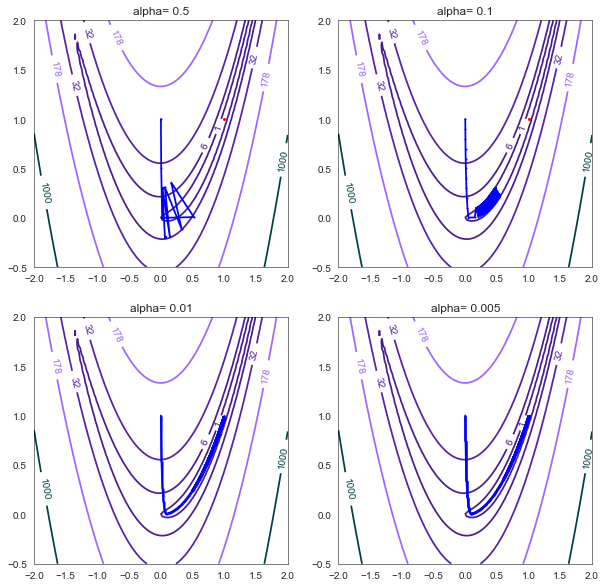

In [14]:
x0=np.array([0,1])

def run_GD(x,alpha,epsilon,maxiter,fig,fn,cn):
    k=0
    delta=10
    xplt=[x[0]]
    yplt=[x[1]]
    while (delta > epsilon and k <=maxiter):
        d=calculate_descent(x[0],x[1])
        xnew=x- alpha*d
        xnew=np.transpose(xnew)
        delta= np.linalg.norm(xnew-x)
        x=xnew.flatten()
        xplt.append(x[0])
        yplt.append(x[1])
        k=k+1
    print('Solution with alpha= ',a, ' after ',k,' iterations: f(',x[0],',',x[1],')=',func(x[0],x[1])) 
    levels = np.logspace(0, 3,5)
    frows=int(ceiling(fn/2))
    fcols=2
    X,Y,Z = make_contours()
    ax1 = fig.add_subplot(frows,fcols,cn)
    contour_plt=ax1.contour(X, Y, Z,levels) 
    plt.clabel(contour_plt, inline=1, fontsize=10, fmt =  '%1.0f')
    ax1.plot([1],[1],'ro',markersize=3)
    ax1.plot(xplt,yplt,'bo-',markersize=2)
    ax1.title.set_text("alpha= "+str(alpha))
fig= plt.figure(figsize=(10,10))
cn=0
alphas=[0.5,0.1,0.01,0.005]
epsilon=1e-3
maxiter=10000
for a in alphas:
    cn=cn+1
    run_GD(x0,a,epsilon,maxiter,fig,len(alphas),cn)

We see that $\alpha=0.5$ fails to converge, $\alpha=0.1$ seems it would converge but is very slow, and the other two converge but reach the maximum number of iterations before they achieve the required accuracy. 

As we mentioned before, there are many methods to adjust the parameter $\alpha$. One such method is the line search with backtracking, which we implement below. The algorithm starts with an initial value for $\alpha$ and two parameters $\rho$ and $c$. It reduces $\alpha$ until the condition (known as Wolfe's condition)
$$f(\mathbf{x}^k +\alpha p_k) \le f(\mathbf{x}^k)+c \alpha \nabla f_k^T p_k$$
is satisfied, where $p_k$ is the direction at iteration $k$. 

In [15]:
def find_alpha(x,p,nab):
    fv=lambdify((x1,x2),100*(x2-x1**2)**2+(1-x1)**2)
    rho=0.5 
    c=0.001
    alpha=1.0
    pt=np.transpose(p.flatten())
    xn=x-alpha* pt
    gr=nab(x[0],x[1]).flatten()
    mprod=np.matmul(gr,p.flatten())
    fk=fv(x[0],x[1])
    while fv(xn[0],xn[1]) > fk + c* alpha * mprod:
        alpha = rho* alpha
        xn=x-alpha* pt
    return alpha

The following is the updated algorithm in which we adjust $\alpha$ at each iteration.

In [16]:
def run_GD_LS(x,epsilon,maxiter):
    k=0
    delta=10
    xplt=[x[0]]
    yplt=[x[1]]
    while (delta > epsilon and k <=maxiter):
        d=calculate_descent(x[0],x[1])
        alpha=find_alpha(x,d,g)
        xnew=x-alpha*d
        xnew=np.transpose(xnew)
        delta= np.linalg.norm(xnew-x)
        x=xnew.flatten()
        xplt.append(x[0])
        yplt.append(x[1])
        k=k+1
    print('Solution after ',k,' iterations: f(',x[0],',',x[1],')=',func(x[0],x[1])) 
    X,Y,Z=make_contours()
    levels = np.logspace(0, 3,5)
    fig,ax1= plt.subplots(figsize=(6,6))
    ax1.contour(X, Y, Z,levels) 
    ax1.plot([1],[1],'ro',markersize=3)
    ax1.plot(xplt,yplt,'bo-',markersize=2)


Solution after  6801  iterations: f( 0.9992472141473394 , 0.9986286012803194 )= 2.351750855902934e-06


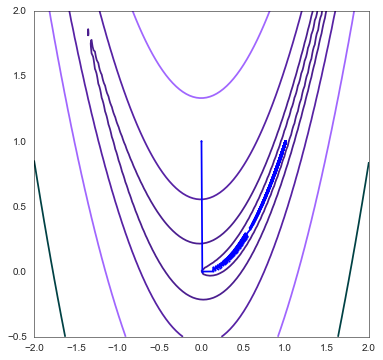

In [17]:
run_GD_LS([0,1],1e-3,10000)

This time, the algorithm terminated earlier, achieving the required accuracy.

In the following notebooks of this module we will cover algorithms that are commonly used in hybrid (i.e., classical and quantum) schemes. In particular, we will describe the following algorithms:
*  Sequential Quadratic Programming (SQP)
*  Broyden-Fletcher-Goldfarb-Shanno (BFGS)
*  Nelder-Mead
*  Constrained Optimization By Linear Approximation (COBYLA)
*  Simultaneous Perturbation Stochastic Approximation (SPSA)

<span style="font-size:10pt; font-weight:bold;"> &copy; Copyright IBM Corp. 2023 <br/>This content is categorized as an “existing” IBM asset as part of the IBM Quantum Accelerator contract. </span>